<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span></li></ul></div>

# Import

In [ ]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


# Functions

# Main

In [3]:
data = scprep.io.load_csv("../data/moein_data/moein.data.csv", cell_axis = "column")
metadata = scprep.io.load_csv("../data/moein_data/moein.meta_data.csv")

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\sanitize.py:53: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  RuntimeWarning,


In [24]:
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 13592 observations and 3897 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 47.39 seconds.
    Calculating affinities...
    Calculated affinities in 31.31 seconds.
  Calculated graph and diffusion operator in 89.38 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.33 seconds.
    Calculating KMeans...
    Calculated KMeans in 26.84 seconds.
  Calculated landmark operator in 34.21 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 5.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.19 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.13 seconds.
Calculated PHATE in 138.21 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

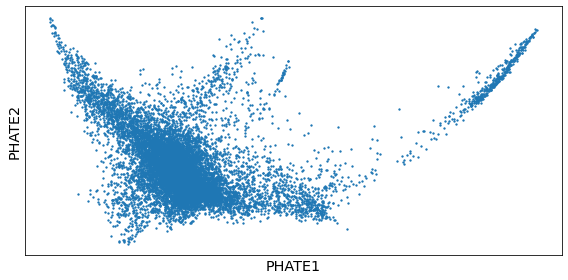

In [25]:
scprep.plot.scatter2d(data_phate, figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

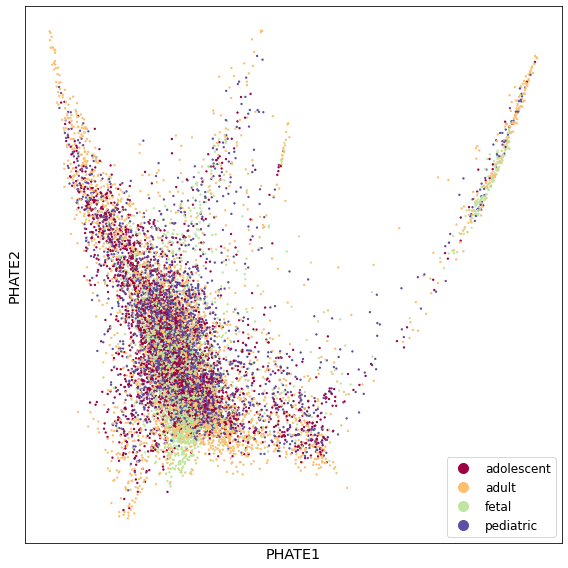

In [27]:
scprep.plot.scatter2d(data_phate, c=metadata["age"],figsize=(8,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [28]:
sub_data = data[metadata['age'] != 'fetal']
sub_metadata = metadata[metadata['age'] != 'fetal']
sub_metadata

proportion_cluster(data, 'seurat_clusters', 'age') => retourne dataframe de proportion 

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.6,seurat_clusters,age,S.Score,G2M.Score,Phase,integrated_snn_res.0.4
TCGCGAGGTTTAGGAA_1,HP773,1034.0,650,3.288201,3.0,5,pediatric,-0.023260,-0.018602,G1,5
ACCTTTATCGTGACAT_1,HP773,2673.0,1391,3.179948,4.0,0,pediatric,-0.051620,0.117481,G2M,0
CGGAGCTTCCGCATCT_1,HP773,927.0,610,1.402373,3.0,0,pediatric,-0.037142,-0.079287,G1,0
CGCTGGAGTCGTTGTA_1,HP773,1820.0,1034,3.241758,3.0,0,pediatric,0.005744,0.011691,G2M,0
GTGTGCGAGCGGCTTC_1,HP773,617.0,365,3.727715,2.0,6,pediatric,-0.009725,-0.019488,G1,6
...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCAGTGGTTCT_9,HA801,1938.0,1301,5.624355,2.0,1,adult,0.054159,0.071449,G2M,1
TTTGATCGTAGACAGC_9,HA801,1236.0,881,9.789644,2.0,1,adult,0.024586,0.038337,G2M,1
TTTGATCGTGCGAACA_9,HA801,3592.0,1428,11.469933,0.0,4,adult,-0.017181,-0.038501,G1,4
TTTGGTTGTGGAACCA_9,HA801,3798.0,1737,9.320695,0.0,0,adult,-0.023995,-0.015911,G1,0


In [29]:

sub_data_phate = phate.PHATE().fit_transform(sub_data)


Calculating PHATE...
  Running PHATE on 10198 observations and 3897 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 27.38 seconds.
    Calculating affinities...
    Calculated affinities in 15.52 seconds.
  Calculated graph and diffusion operator in 48.86 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.33 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.71 seconds.
  Calculated landmark operator in 27.97 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 5.47 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.20 seconds.
Calculated PHATE in 91.55 seconds.


In [30]:
sub_data_phate = pd.DataFrame(sub_data_phate, index=sub_data.index)

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

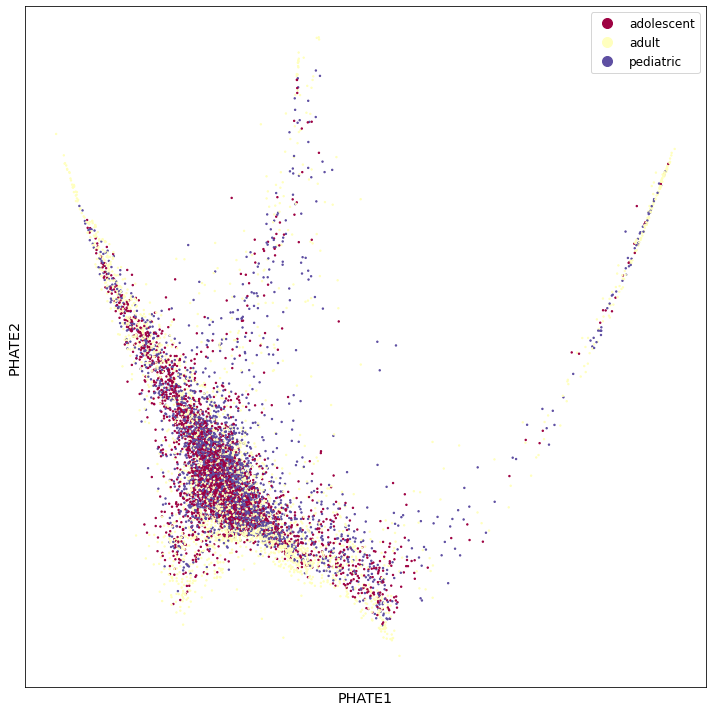

In [31]:
scprep.plot.scatter2d(sub_data_phate,c=sub_metadata["age"],figsize=(10,10), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [7]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.6,seurat_clusters,age,S.Score,G2M.Score,Phase,integrated_snn_res.0.4
TCGCGAGGTTTAGGAA_1,HP773,1034.000000,650,3.288201,3.0,5,pediatric,-0.023260,-0.018602,G1,5
ACCTTTATCGTGACAT_1,HP773,2673.000000,1391,3.179948,4.0,0,pediatric,-0.051620,0.117481,G2M,0
CGGAGCTTCCGCATCT_1,HP773,927.000000,610,1.402373,3.0,0,pediatric,-0.037142,-0.079287,G1,0
CGCTGGAGTCGTTGTA_1,HP773,1820.000000,1034,3.241758,3.0,0,pediatric,0.005744,0.011691,G2M,0
GTGTGCGAGCGGCTTC_1,HP773,617.000000,365,3.727715,2.0,6,pediatric,-0.009725,-0.019488,G1,6
...,...,...,...,...,...,...,...,...,...,...,...
CTGCCTACAAGCTGAG_12,HF588,804.302460,337,1.001472,0.0,2,fetal,0.105172,-0.052438,S,2
TCGCGAGGTTGCTCCT_12,HF588,772.912931,310,1.519034,0.0,2,fetal,-0.004290,-0.050681,G1,2
AGAGCTTTCACCCGAG_12,HF588,930.952502,446,1.893067,2.0,0,fetal,-0.032441,-0.032703,G1,0
CTCGAAAAGATCGGGT_12,HF588,882.212233,393,2.471061,1.0,2,fetal,-0.018380,0.063663,G2M,2
